In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from tqdm.auto import tqdm

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"

# Paths and Configs
import yaml
with open('../configuration/config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
TEMPDIR = Path(config['TEMPDIR'])

# SRR3845160: SRX1929540  # sc-chip
# SRR3845161: SRX1929542  # sc-input


In [95]:
# Load gene and transcript information
with open('../../gene_info.yaml') as f:
    gene_info = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
file = '../results/contrast_annotated_peaks_2.csv'
df = pd.read_csv(file, index_col=0)

from gtfparse import read_gtf
gtf = read_gtf("/g/huber/users/peidli/utils/genomes/drosophila_melanogaster/Drosophila_melanogaster.BDGP6.46.110.gtf")
gtf = pd.DataFrame(gtf, columns=gtf.columns)

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_name', 'transcript_source', 'transcript_biotype', 'exon_number', 'exon_id', 'protein_id', 'tag']


In [96]:
def contrasted_annotation(gene_name, ylim=(-6, 10)):
    chrom = gene_info[gene_name]['chrom']
    start = gene_info[gene_name]['start']
    end = gene_info[gene_name]['end']
    
    # subset data to gene
    sgtf = gtf[gtf.gene_name == gene_name].copy()
    sdf = df[df['gene'] == gene_name]
    
    # Get features to plot
    transcripts = sgtf[(sgtf.feature=='transcript')]
    transcripts = transcripts[~transcripts.transcript_id.duplicated()]
    exons = sgtf[sgtf.feature=='exon']
    if gene_name=='CG9650':
        transcripts = transcripts[(transcripts.start > 7.16 * 1e6)]
    
    # Translate transcript names
    if 'transcripts' in gene_info[gene_name]:
        transcript_dict = gene_info[gene_name]['transcripts']
        transcripts.transcript_id.replace(transcript_dict, inplace=True)
        sdf.transcriptId.replace(transcript_dict, inplace=True)
        exons = exons[exons.transcript_id.isin(transcript_dict.keys())]
    if gene_name=='CG9650':
        exons = exons.iloc[:4]  # only main exons
    
    # get TSS sites
    TSS = {}
    for i, row in sdf.iterrows():
        TSS[row.transcriptId] = row.chromStart - row.distanceToTSS
    palette = dict(zip(sdf.transcriptId.unique(), sns.color_palette('tab10', len(sdf.transcriptId.unique()))))

    
    # Make the plot
    with sns.axes_style('darkgrid'):
        fig, ax = pl.subplots(figsize=(12, 4))
    ykey = 'signalValue'

    # assign colors
    palette = dict(zip(sdf.transcriptId.unique(), sns.color_palette('tab10', len(sdf.transcriptId.unique()))))
    # remove substrings like "FBtr0339815/FBgn0029939 " from annotation with regex
    sdf['annotation_clean'] = sdf['annotation'].str.replace(r'FB(gn|tr)\d+', '', regex=True).str.replace('/, ', '').str.replace('\(intron ', '(').str.replace('\(exon ', '(')

    # add horizontal annotations
    offset = -0.3
    ax.axhline(0, color='black', linewidth=1)
    ax.plot([start, end], [offset, offset], color='black', linewidth=7)
    ax.text((start + end)/2, offset + 0.2, gene_name, fontsize=16, ha='center', va='bottom')
    
    # add transcript annotations
    already_plotted = []
    for i, (idx, row) in enumerate(transcripts.iterrows()):
        if row.transcript_id in already_plotted:
            continue
        start = row['start']
        end = row['end']
        offset = -1 - i/2
        pl.plot([start, end], [offset, offset], linewidth=7, alpha=0.5, label=row.transcript_id)
        already_plotted.append(row.transcript_id)
        i+=1
    print(already_plotted)
    
    # add exon annotations
    # for i, (idx, row) in enumerate(exons.iterrows()):
    #     start = row['start']
    #     end = row['end']
    #     offset = -2
    #     pl.plot([start, end], [offset, offset], linewidth=7, alpha=0.5, label=f'Exon {i+1}')

    # Add peaks
    # texts = []
    for idx, tag in sdf.iterrows():
        transcript = tag.transcriptId  # color by this
        ax.fill_between([tag.chromStart, tag.chromEnd], [tag[ykey], tag[ykey]], 0, 
                        color=palette[transcript], 
                        alpha=1, label=transcript)
        x = (tag.chromStart + tag.chromEnd)/2
        y = tag[ykey]
        # text = ax.annotate(tag.annotation_clean, 
        #                    xy=(x, y), 
        #                    xytext=(x, y+3), 
        #                    fontsize=6, ha='left', va='bottom', rotation=0,
        #                    arrowprops=dict(facecolor='black', arrowstyle='->', alpha=0.5))
        # texts.append(text)

    # Add TSS
    for transcript, pos in TSS.items():
        color = palette[transcript]
        ax.axvline(pos, color=color, linestyle='--', linewidth=2, label=f'TSS {transcript}')
        ax.fill_between([pos-3000, pos+3000], [0, 0], [80, 80], color=color, alpha=0.1, label='Promoter region')

    # Plot options
    ax.set_ylabel('Summit height')
    ax.set_xlabel('Genomic position')
    ax.set_title('Significant MACS2 Peaks in gene pros with gene structure and TSSs')
    ax.set_ylim(*ylim)
    ax.set_yticks([0,2,4,6,8,10])

    # from adjustText import adjust_text
    # adjust_text(texts, only_move={'text':'y'}, expand=(1,1))

    # Make legend show unique entries
    handles, labels = pl.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    pl.legend(by_label.values(), by_label.keys(), title='Legend', loc='lower left', bbox_to_anchor=(1, 0))


['pros-RI', 'pros-RL', 'pros-RK', 'pros-RJ', 'pros-RM', 'pros-RH']


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 50 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 29, 36, 37, 38, 42, 43, 44, 45, 46, 47, 48, 4

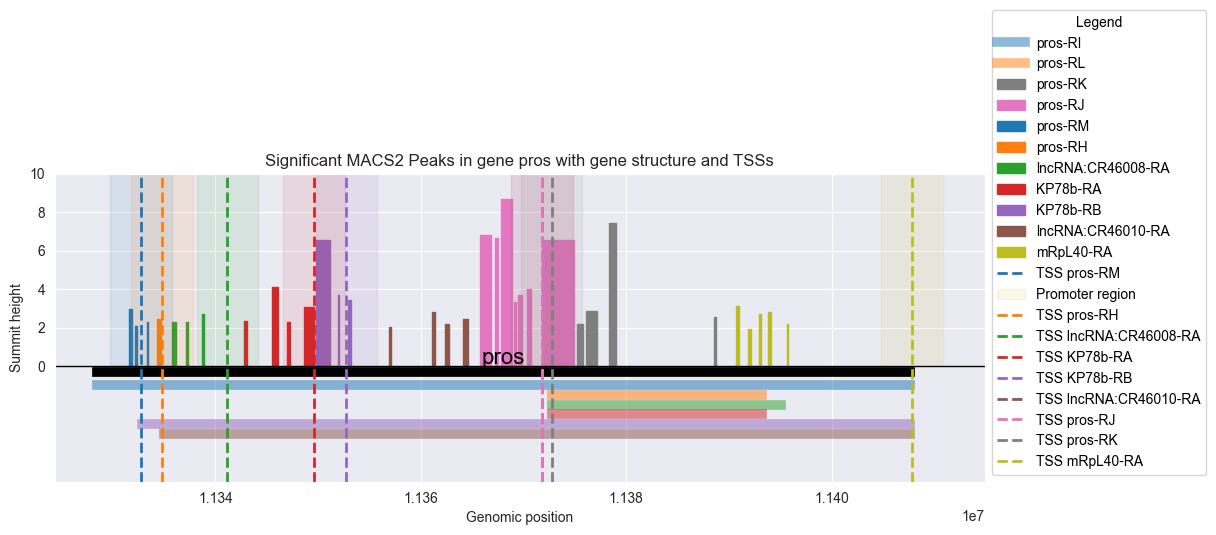

In [97]:
gene_name = 'pros'
contrasted_annotation(gene_name)
pl.savefig(f'../results/peaks_in_gene_{gene_name}.pdf', bbox_inches='tight')
pl.show()

['Cph-RI', 'Cph-RK/Cph-RL']


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'I', 'K', 'L', 'M', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 38, 42, 44, 46, 47, 48, 51, 53, 54, 55, 68,

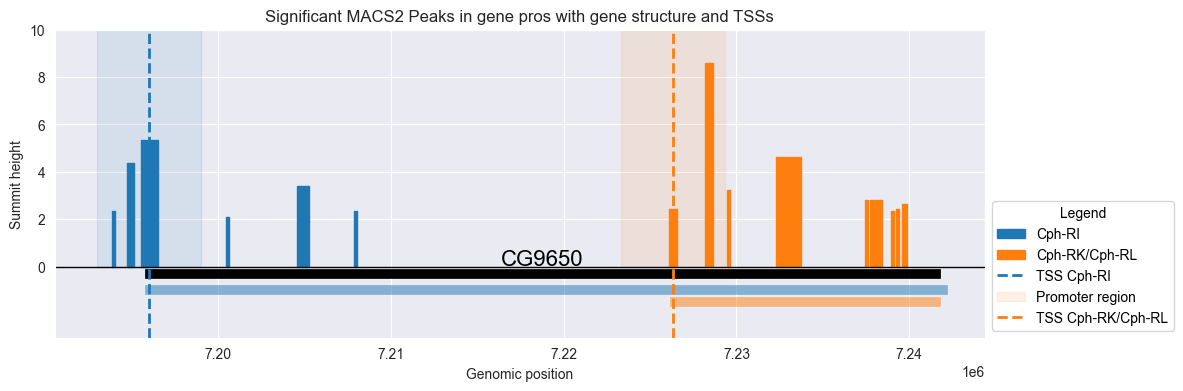

In [98]:
gene_name = 'CG9650'
contrasted_annotation(gene_name, ylim=(-3, 10))
pl.savefig(f'../results/peaks_in_gene_{gene_name}.pdf', bbox_inches='tight')
pl.show()

['Rh4-RA']


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'L', 'M', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 36, 38, 42, 47, 48, 51, 53, 54, 55, 68, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 85, 86,

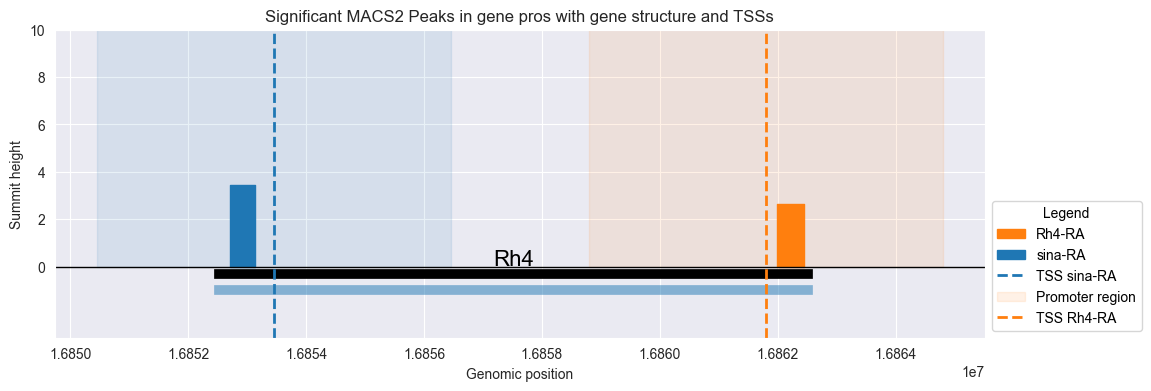

In [99]:
contrasted_annotation(gene_name='Rh4', ylim=(-3, 10))
pl.savefig(f'../results/peaks_in_gene_Rh4.pdf', bbox_inches='tight')
pl.show()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before


['Rh3-RA']


INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'L', 'M', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 36, 38, 42, 47, 48, 51, 53, 54, 55, 68, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 85, 86, 87, 88, 90]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 42 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'G', 'L', 'M', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 36, 38, 42, 47,

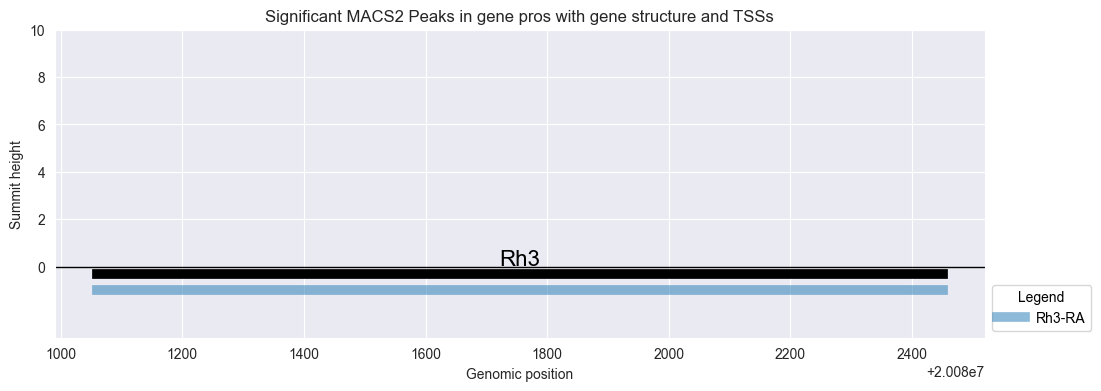

In [100]:
contrasted_annotation(gene_name='Rh3', ylim=(-3, 10))
pl.savefig(f'../results/peaks_in_gene_Rh3.pdf', bbox_inches='tight')
pl.show()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before


['Pdh-RA', 'Pdh-RD', 'Pdh-RC', 'Pdh-RB']


INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'L', 'M', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38, 39, 42, 47, 48, 51, 53, 54, 55, 68, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 85, 86, 87, 88, 90]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 45 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'L', 'M', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'plus', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 14, 16, 17,

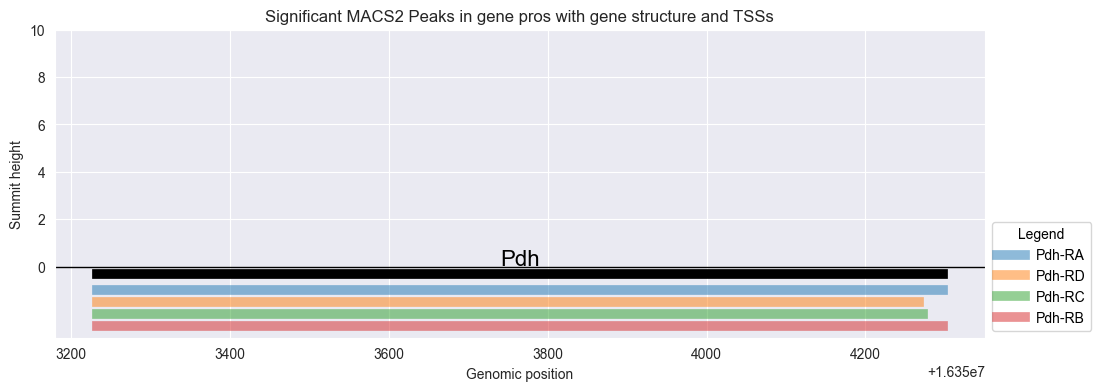

In [101]:
contrasted_annotation(gene_name='Pdh', ylim=(-3, 10))
pl.savefig(f'../results/peaks_in_gene_Pdh.pdf', bbox_inches='tight')
pl.show()

# Motifs (CANNTG is not enriched in the peaks of Cph TSSs)

In [38]:
# Contains sites of CANNTG motifs with position w.r.t. peaks
# Includes Strand info. Cph is on + strand, relevant?
# MotifScore is always just 5.533159, basically useless.
motif_df = pd.read_csv(TEMPDIR / 'homer/contrast_peaks_homer_motifs.tsv', index_col=0, sep='\t')

In [39]:
# Add number of motifs per peak to annotated peaks
df = pd.read_csv('../results/contrast_peaks_annotated.csv', index_col=0)
n_motif = motif_df.groupby('PositionID').size().to_frame()
df['CANNTG_motifs'] = 0
df.loc[n_motif.index, 'CANNTG_motifs'] = n_motif[0]

# Remove insignificant peaks
df = df[df['qValue'] > -np.log10(0.05)]
# Only keep peaks in TSS region
df = df[np.abs(df.distanceToTSS) < 3000]
# Only longer genes
df = df[df.geneLength > 1000]
# Remove intergenic peaks
df = df[df.gene != 'intergenic']

In [40]:
genewise_df = df.groupby(['gene', 'transcriptId', 'geneLength'])['CANNTG_motifs'].sum().reset_index().set_index(['gene', 'transcriptId'])
genewise_df['CANNTG_motifs_per_kB'] = 1000 * genewise_df['CANNTG_motifs'] / genewise_df['geneLength']

In [41]:
genewise_df

geneLength  CANNTG_motifs  CANNTG_motifs_per_kB
gene          transcriptId                                                 
128up         FBtr0087976         1554              2              1.287001
1360{}6424    FBtr0301812         1991              0              0.000000
14-3-3epsilon FBtr0083567         5893              0              0.000000
14-3-3zeta    FBtr0088418        10011              6              0.599341
              FBtr0088419         8652              2              0.231160
...                                ...            ...                   ...
zormin        FBtr0346823         1070              0              0.000000
zpg           FBtr0076976         5056              8              1.582278
zuc           FBtr0080316         1148              0              0.000000
zyd           FBtr0340198         7113              2              0.281175
zye           FBtr0078233         1648              4              2.427184

[11887 rows x 3 columns]

In [42]:
genewise_df.loc['CG9650']

,geneLength,CANNTG_motifs,CANNTG_motifs_per_kB
transcriptId,,,
FBtr0309030,45904,2,0.043569
FBtr0474234,15084,0,0.000000
FBtr0474235,15084,4,0.265182


In [43]:
# Now use some test per transcript. Probably t-test on motif density.

In [44]:
results = []
from scipy.stats import ttest_ind
background_density = genewise_df.CANNTG_motifs

for (gene, transcript), row in tqdm(genewise_df.iterrows(), total=len(genewise_df)):
    observed_density = row.CANNTG_motifs
    res = ttest_ind(observed_density, background_density)
    results.append([gene, transcript, res.pvalue])

  0%|          | 0/11887 [00:00<?, ?it/s]

In [45]:
test_results = pd.DataFrame(results, columns=['gene', 'transcript', 'pvalue']).set_index(['gene', 'transcript'])
df = pd.concat([genewise_df, test_results], axis=1)

In [46]:
df.mean()

geneLength              7467.937579
CANNTG_motifs              4.010432
CANNTG_motifs_per_kB       1.452752
pvalue                     0.538867
dtype: float64

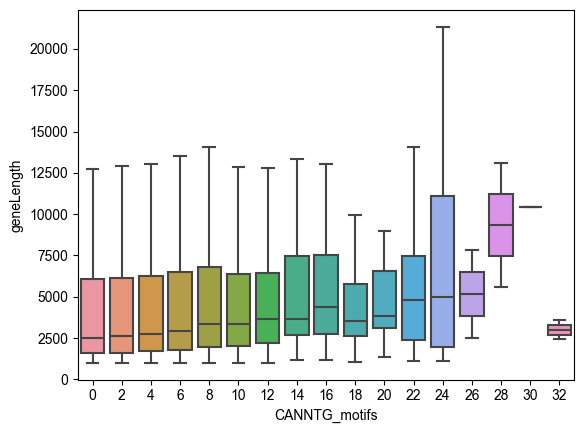

In [47]:
sns.boxplot(data=df, x='CANNTG_motifs', y='geneLength', showfliers=False)
pl.show()

In [51]:
df.loc['CG9650', 'pvalue']

FBtr0309030    0.582896
FBtr0474234    0.273320
FBtr0474235    0.997726
Name: pvalue, dtype: float64

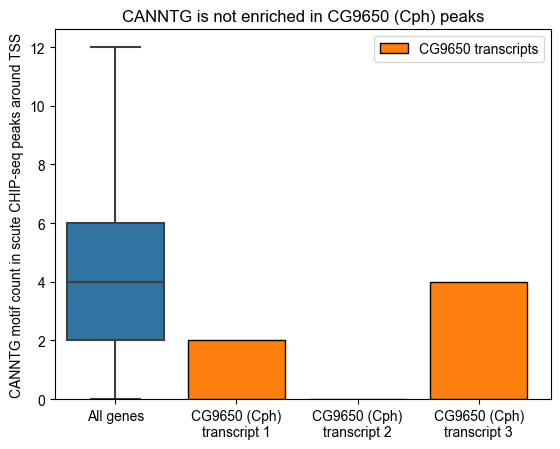

In [50]:
sns.boxplot(data=df, y='CANNTG_motifs', showfliers=False)
pl.bar([1,2,3], df.loc['CG9650', 'CANNTG_motifs'], color='tab:orange', label='CG9650 transcripts', edgecolor='black')
pl.legend()
pl.ylabel('CANNTG motif count in scute CHIP-seq peaks around TSS')
pl.title('CANNTG is not enriched in CG9650 (Cph) peaks')
pl.xticks([0,1,2,3], ['All genes', 'CG9650 (Cph)\ntranscript 1', 'CG9650 (Cph)\ntranscript 2', 'CG9650 (Cph)\ntranscript 3'])
pl.show()

In [228]:
df.loc['CG9650', 'CANNTG_motifs']

FBtr0309030    2
FBtr0474234    0
FBtr0474235    4
Name: CANNTG_motifs, dtype: int64

In [235]:
df.loc['CG9650'].mean()

geneLength              25357.333333
CANNTG_motifs               2.000000
CANNTG_motifs_per_kB        0.102917
pvalue                      0.617981
dtype: float64

In [226]:
df.sort_values('pvalue').head(20)

,,geneLength,CANNTG_motifs,CANNTG_motifs_per_kB,pvalue
gene,,,,,
CG2202,FBtr0073380,3571,32,8.961075,2.237992e-14
CG7546,FBtr0346947,2413,32,13.261500,2.237992e-14
Muc12Ea,FBtr0475073,10427,30,2.877146,1.324629e-12
Doa,FBtr0299743,13118,28,2.134472,5.870420e-11
CG42268,FBtr0475017,5600,28,5.000000,5.870420e-11
Epac,FBtr0329851,7846,26,3.313790,1.948494e-09
Ets21C,FBtr0112854,2487,26,10.454363,1.948494e-09
Gmap,FBtr0343525,21343,24,1.124490,4.846234e-08
Usp12-46,FBtr0084319,2267,24,10.586678,4.846234e-08


# Outdated: Reprocessed

In [8]:
df_chip = pd.read_csv(TEMPDIR / 'macs2/SRR3845160_peaks.narrowPeak', sep='\t', header=None)
df_chip.columns = ["chrom", "chromStart", "chromEnd", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]
df_chip['condition'] = 'sc-chip'
df_input = pd.read_csv(TEMPDIR / 'macs2/SRR3845161_peaks.narrowPeak', sep='\t', header=None)
df_input.columns = ["chrom", "chromStart", "chromEnd", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]
df_input['condition'] = 'sc-input'
df = pd.concat([df_chip, df_input])

In [11]:
# define genes and regions
genes = pd.DataFrame([
    ['Cph', 'X', 7137723, 7241932],
    ['sepia', '3L', 8520552, 8521489],
    ['Apc', '3R', 28832301, 28844748],
    ['CG42795', '3R', 10225690, 10251277],
], columns=['name', 'chrom', 'chromStart', 'chromEnd']).set_index('name')
window_factor = 5
for gene_name, chr, start, end in genes.itertuples():
    gene_length = end - start
    df[f'{gene_name}_region'] = False
    df.loc[(df.chrom == chr) & (df.chromStart >= start) & (df.chromEnd <= end), f'{gene_name}_region'] = True
    width = window_factor * gene_length
    df[f'{gene_name}_window'] = False
    df.loc[(df.chrom == chr) & (df.chromStart >= start - width) & (df.chromEnd <= end + width), f'{gene_name}_window'] = True

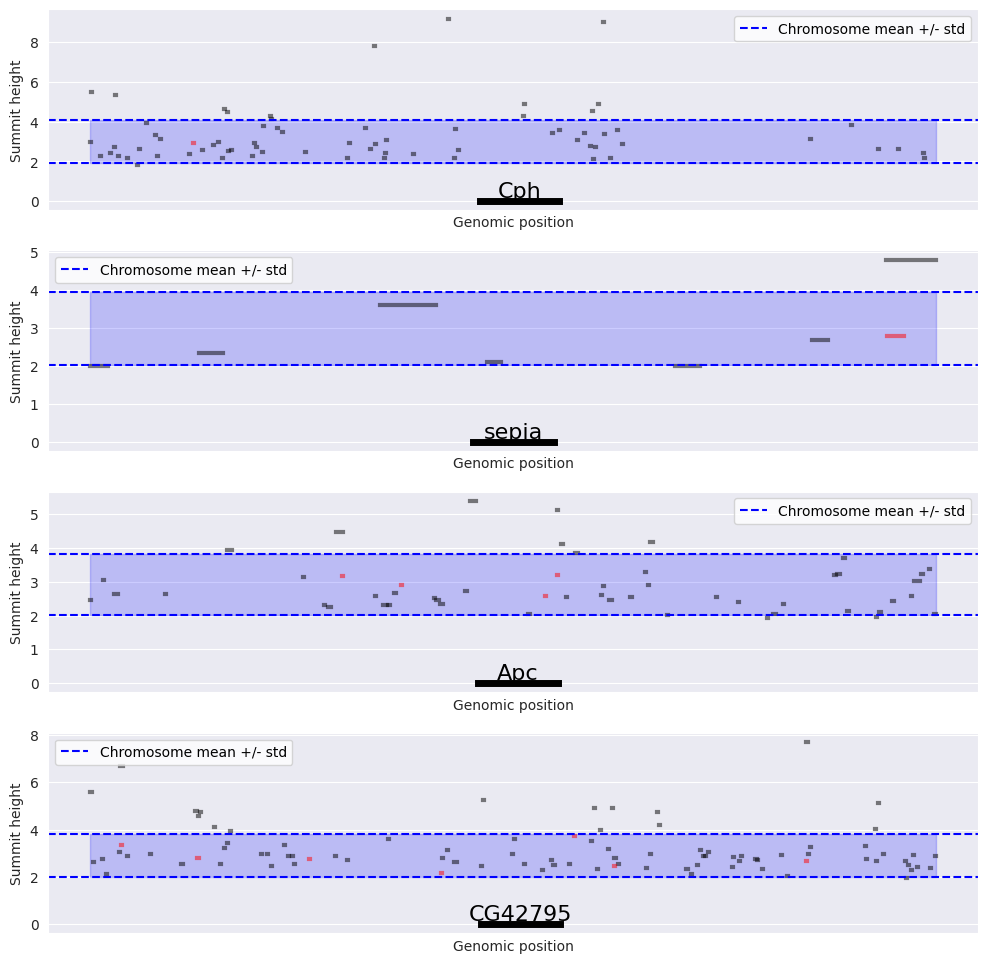

In [12]:
N = len(genes)
y = 'signalValue'

with sns.axes_style('darkgrid'):
    fig, axs = pl.subplots(N, 1, figsize=(12, 3*N))
for i, (gene_name, chr, start, end) in enumerate(genes.itertuples()):
    sdf = df[df[f'{gene_name}_window']]
    # sdf['color'] = sdf[f'{gene_name}_region'].map({True: 'black', False: 'red'})
    sdf['color'] = sdf['condition'].map({'sc-chip': 'black', 'sc-input': 'red'})
    ax = axs[i]
    ax.plot([start, end], [0, 0], color='black', linewidth=5)
    ax.text((start + end)/2, 0, gene_name, fontsize=16, ha='center', va='bottom')
    for idx, tag in sdf.iterrows():
        ax.plot([tag.chromStart, tag.chromEnd], [tag[y], tag[y]], 
                color=tag.color, alpha=0.5,
                linewidth=3)
    ax.set_ylabel('Summit height')
    ax.set_xlabel('Genomic position')
    ax.set_xticks([])
    
    std = df[(df.chrom == chr)][y].std()
    mean = df[(df.chrom == chr)][y].mean()
    ax.axhline(mean + std, color='blue', linestyle='--', label='Chromosome mean +/- std')
    ax.axhline(mean - std, color='blue', linestyle='--')
    # fill entire horizontal space
    ax.fill_between([sdf.chromStart.min(), sdf.chromEnd.max()], [mean + std, mean + std], [mean - std, mean - std], color='blue', alpha=0.2)
    ax.legend()
pl.show()

In [13]:
# number of peaks in gene
counts = {}
for i, (gene_name, chr, start, end) in enumerate(genes.itertuples()):
    sdf = df[df[f'{gene_name}_region']]
    x=sdf.condition.astype('category')
    counts[gene_name] = x.cat.set_categories(['sc-chip', 'sc-input']).value_counts().to_frame()
tab = pd.concat(counts, axis=0).reset_index()

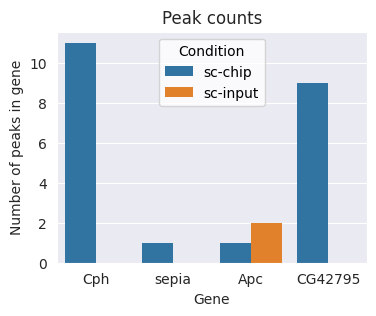

In [14]:
with sns.axes_style('darkgrid'):
    fig, ax = pl.subplots(figsize=(4,3))
sns.barplot(data=tab, x='level_0', y='condition', hue='level_1')
pl.ylabel('Number of peaks in gene')
pl.xlabel('Gene')
pl.legend(title='Condition')
pl.title('Peak counts')
pl.show()

In [15]:
# occupancy (how much is covered with peaks?)
occ = {}
for i, (gene_name, chr, start, end) in enumerate(genes.itertuples()):
    for condition in df.condition.unique():
        sdf = df[(df[f'{gene_name}_region']) & (df.condition==condition)]
        s = np.clip(sdf.chromStart, start, None)
        e = np.clip(sdf.chromEnd, None, end)
        o = np.sum(e-s) / (end - start)
        occ[(gene_name, condition)] = o

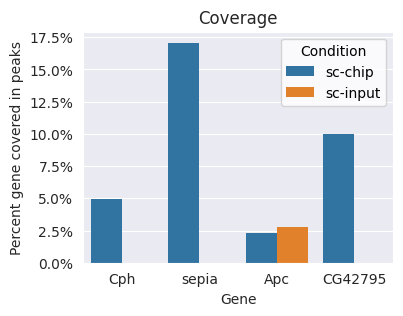

In [16]:
tab = pd.Series(occ).reset_index()
with sns.axes_style('darkgrid'):
    fig, ax = pl.subplots(figsize=(4,3))
sns.barplot(data=tab, x='level_0', y=0, hue='level_1')
pl.ylabel('Percent gene covered in peaks')
pl.xlabel('Gene')
pl.legend(title='Condition')
pl.title('Coverage')

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

pl.show()

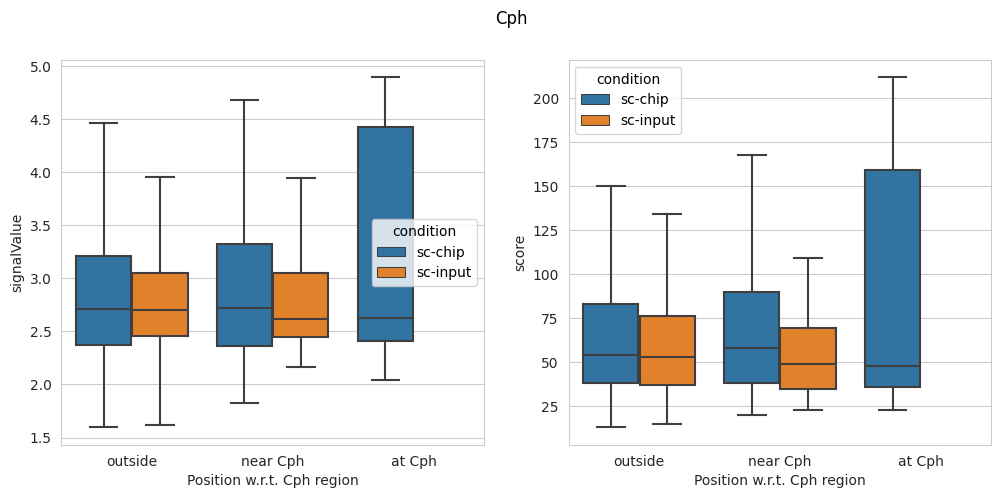

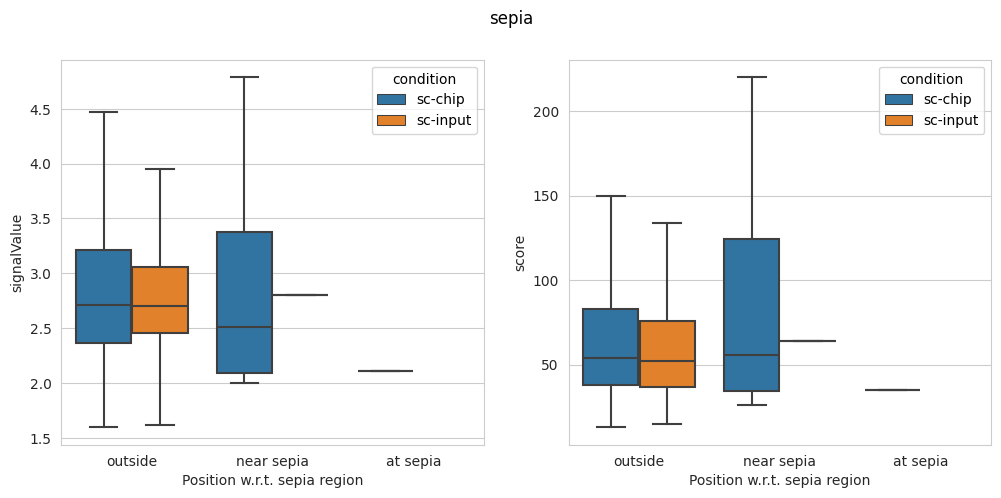

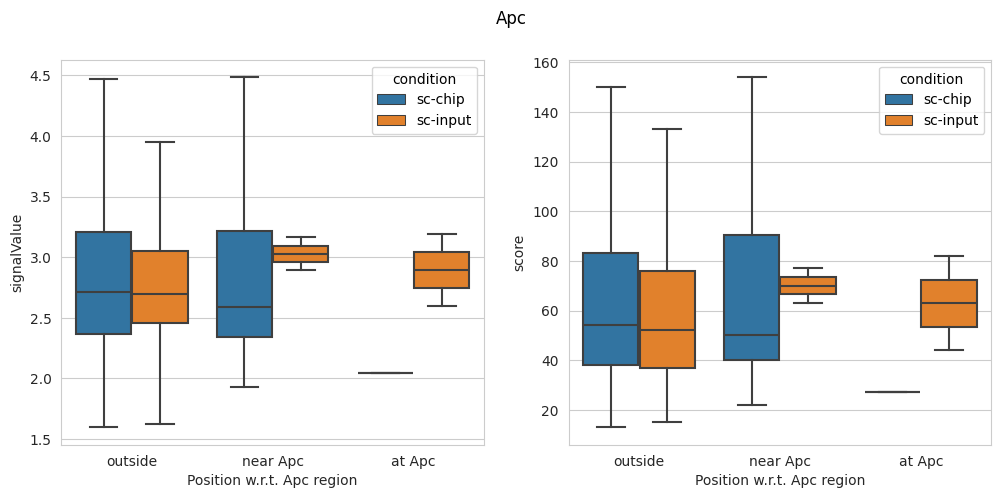

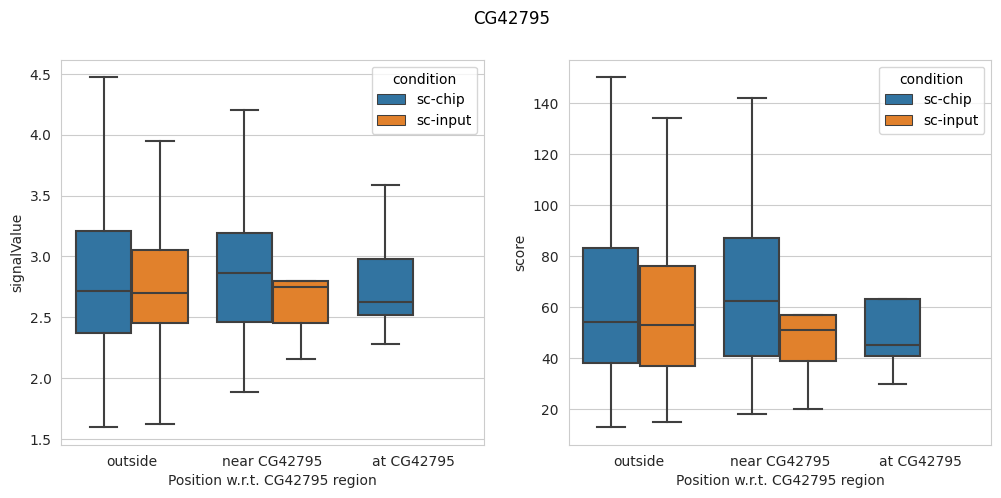

In [17]:
for gene in genes.index.unique():
    df['region'] = 'outside'
    df.loc[df[f'{gene}_window'], 'region'] = f'near {gene}'
    df.loc[df[f'{gene}_region'], 'region'] = f'at {gene}'

    with sns.axes_style('whitegrid'):
        fig, axs = pl.subplots(1, 2, figsize=(6*2, 5))

    ax = axs[0]
    sns.boxplot(data=df, x='region', y='signalValue', hue='condition', showfliers=False, ax=ax)
    ax.set_xlabel(f'Position w.r.t. {gene} region')

    ax = axs[1]
    sns.boxplot(data=df, x='region', y='score', hue='condition', showfliers=False, ax=ax)
    ax.set_xlabel(f'Position w.r.t. {gene} region')
    
    pl.suptitle(gene)
    pl.show()

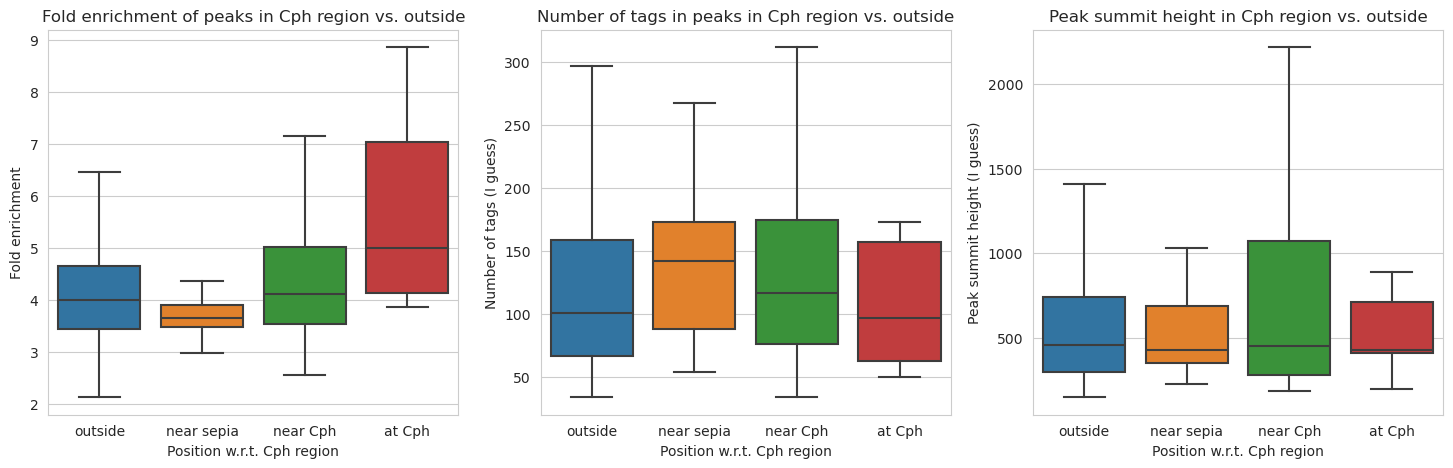

In [13]:
df['region'] = 'outside'
df.loc[df.Cph_window, 'region'] = 'near Cph'
df.loc[df.Cph_region, 'region'] = 'at Cph'

# also annotate sepia
chr = '3L'
start = 8520552
end = 8521489
gene_length = end - start
df['sepia_region'] = False
df.loc[(df.chr == chr) & (df.start >= start) & (df.end <= end), 'sepia_region'] = True
width = 50 * gene_length
df['sepia_window'] = False
df.loc[(df.chr == chr) & (df.start >= start - width) & (df.end <= end + width), 'sepia_window'] = True
df.loc[df.sepia_window, 'region'] = 'near sepia'
df.loc[df.sepia_region, 'region'] = 'at sepia'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, 3, figsize=(6*3, 5))

ax = axs[0]
sns.boxplot(data=df, x='region', y='fold_enrichment', showfliers=False, ax=ax)
ax.set_ylabel('Fold enrichment')
ax.set_xlabel('Position w.r.t. Cph region')
ax.set_title('Fold enrichment of peaks in Cph region vs. outside')

ax = axs[1]
sns.boxplot(data=df, x='region', y='tags', showfliers=False, ax=ax)
ax.set_ylabel('Number of tags (I guess)')
ax.set_xlabel('Position w.r.t. Cph region')
ax.set_title('Number of tags in peaks in Cph region vs. outside')

ax = axs[2]
sns.boxplot(data=df, x='region', y='summit', showfliers=False, ax=ax)
ax.set_ylabel('Peak summit height (I guess)')
ax.set_xlabel('Position w.r.t. Cph region')
ax.set_title('Peak summit height in Cph region vs. outside')

pl.show()

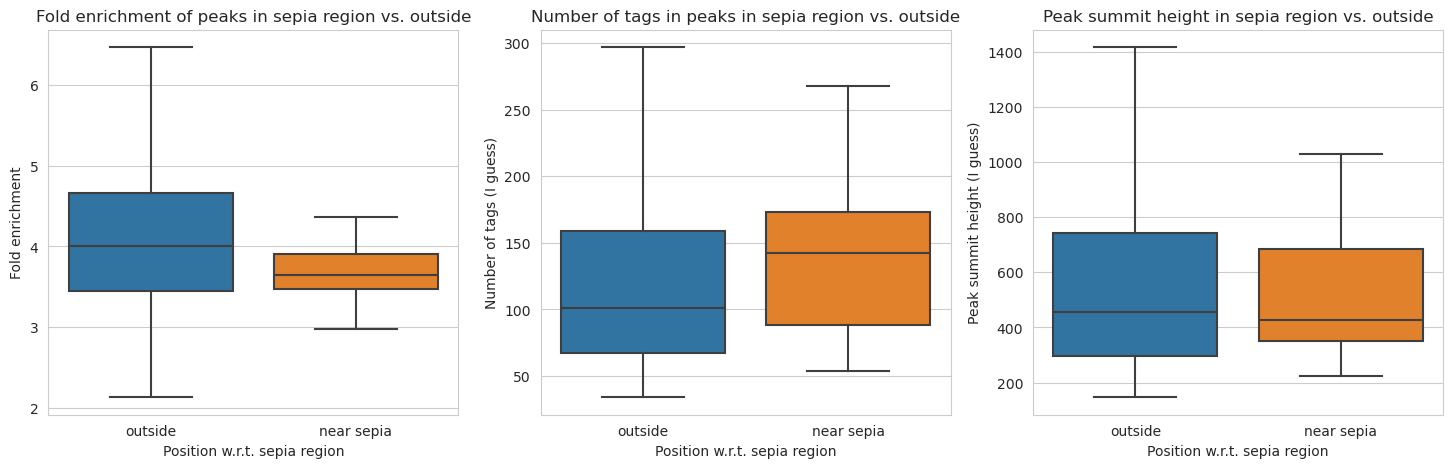

In [12]:
# se is here: 	
# 3L:8,520,552..8,521,489
chr = '3L'
start = 8520552
end = 8521489
gene_length = end - start

df['sepia_region'] = False
df.loc[(df.chr == chr) & (df.start >= start) & (df.end <= end), 'sepia_region'] = True

width = 50 * gene_length
df['sepia_window'] = False
df.loc[(df.chr == chr) & (df.start >= start - width) & (df.end <= end + width), 'sepia_window'] = True

df['region'] = 'outside'
df.loc[df.sepia_window, 'region'] = 'near sepia'
df.loc[df.sepia_region, 'region'] = 'at sepia'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, 3, figsize=(6*3, 5))

ax = axs[0]
sns.boxplot(data=df, x='region', y='fold_enrichment', showfliers=False, ax=ax)
ax.set_ylabel('Fold enrichment')
ax.set_xlabel('Position w.r.t. sepia region')
ax.set_title('Fold enrichment of peaks in sepia region vs. outside')

ax = axs[1]
sns.boxplot(data=df, x='region', y='tags', showfliers=False, ax=ax)
ax.set_ylabel('Number of tags (I guess)')
ax.set_xlabel('Position w.r.t. sepia region')
ax.set_title('Number of tags in peaks in sepia region vs. outside')

ax = axs[2]
sns.boxplot(data=df, x='region', y='summit', showfliers=False, ax=ax)
ax.set_ylabel('Peak summit height (I guess)')
ax.set_xlabel('Position w.r.t. sepia region')
ax.set_title('Peak summit height in sepia region vs. outside')

pl.show()